# Comparison of machine learning algorithms used for analysis of mobile tariffs

**An aim of the research** — build machine learning models:
1. Definition of optimal hyper-parameters
2. Measurement of the models performance on testing data
3. Sanity check of of the models
4. Comparison of algorithms used

**An initial data**

The dataframe is extracted from `users_behavior.csv` file. Due to pre-processing has already been done on the dataset no additional processing or data cleaning is required to carry out the analysis.
 
The research is divided into five staps:
1. Data overview 
2. Splitting data into training, validation and testing
3. Application of classification algorithms for machine learning
4. User personality characteristics
5. Comparison of models

### Step 1. Data overview

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn import tree, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

In [ ]:
# set two decimal places
pd.set_option('precision', 2)

In [ ]:
# read 'users_behavior.csv' and print out 5 rows
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:  
    df = pd.read_csv('C:/YandexPracticumProjects/Project_6_MobileNetwork_ML/users_behavior.csv')

df.loc[0:4].style

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,19915.42,0
1,85.00,516.75,56.00,22696.96,0
2,77.00,467.66,86.00,21060.45,0
3,106.00,745.53,81.00,8437.39,1
4,66.00,418.74,1.00,14502.75,0


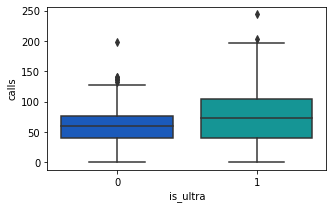

In [ ]:
# vizualization of calls
plt.figure(figsize=(5, 3))
sns.boxplot(x='is_ultra', y='calls',data=df, palette='winter');

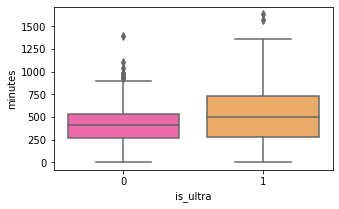

In [ ]:
# vizualization of minutes
plt.figure(figsize=(5, 3))
sns.boxplot(x='is_ultra', y='minutes',data=df, palette='spring');

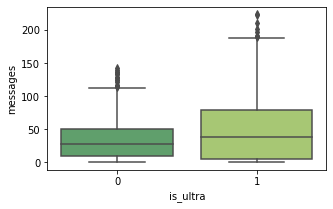

In [ ]:
# vizualization of messages
plt.figure(figsize=(5, 3))
sns.boxplot(x='is_ultra', y='messages',data=df, palette='summer');

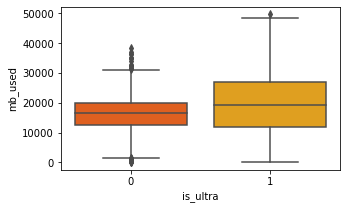

In [ ]:
# vizualization of mb_used
plt.figure(figsize=(5, 3))
sns.boxplot(x='is_ultra', y='mb_used',data=df, palette='autumn');

In [ ]:
# distribution of classes
df.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [ ]:
# multivariate analysis
def mult_anal(data):    
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(data.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()

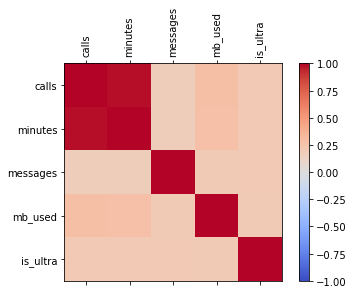

In [ ]:
# print out heatmap of original dataframe
mult_anal(df)

As seen on heatmap, there is a high correlation between calls and minutes

In [ ]:
# correlation matrix
cor_matrix = df.corr().abs()
print(cor_matrix)

          calls  minutes  messages  mb_used  is_ultra
calls      1.00     0.98      0.18     0.29      0.21
minutes    0.98     1.00      0.17     0.28      0.21
messages   0.18     0.17      1.00     0.20      0.20
mb_used    0.29     0.28      0.20     1.00      0.20
is_ultra   0.21     0.21      0.20     0.20      1.00


In [ ]:
# select upper triangle
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
print(upper_tri)

          calls  minutes  messages  mb_used  is_ultra
calls       NaN     0.98      0.18     0.29      0.21
minutes     NaN      NaN      0.17     0.28      0.21
messages    NaN      NaN       NaN     0.20      0.20
mb_used     NaN      NaN       NaN      NaN      0.20
is_ultra    NaN      NaN       NaN      NaN       NaN


In [ ]:
# choose column to drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['minutes']


In [ ]:
# update dataframe
df1 = df.drop(['minutes'], axis=1) 
df1.loc[0:4].style

,calls,messages,mb_used,is_ultra
0,40.00,83.00,19915.42,0
1,85.00,56.00,22696.96,0
2,77.00,86.00,21060.45,0
3,106.00,81.00,8437.39,1
4,66.00,1.00,14502.75,0


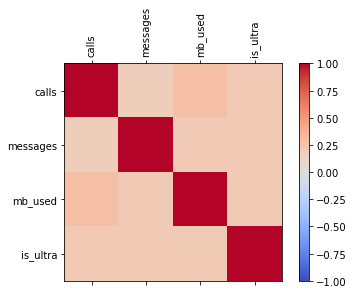

In [ ]:
# print out heatmap of updated dataframe
mult_anal(df1)

### Step 2. Splitting data into training, validation and testing

In [ ]:
# features and target
features = df1.drop(['is_ultra'], axis=1) 
target = df1['is_ultra'] 

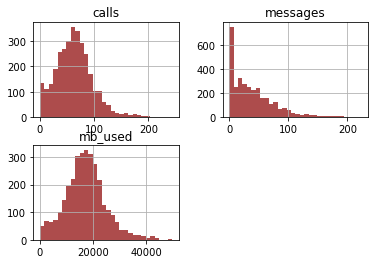

In [ ]:
# vizualization of features
features.hist(bins=30, color='darkred', alpha=0.7);

In [ ]:
# set aside 40% of train and validation data
X_train, X_val, y_train, y_val = train_test_split(features, target, 
    test_size=0.4, random_state=777, stratify=target)

# use the same function above for the test set
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
    test_size=0.5, random_state=777, stratify=y_val)    

In [ ]:
# print out data sets for ML
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1928, 3)
y_train shape: (1928,)
X_val shape: (643, 3)
y val shape: (643,)
X_test shape: (643, 3)
y_test shape: (643,)


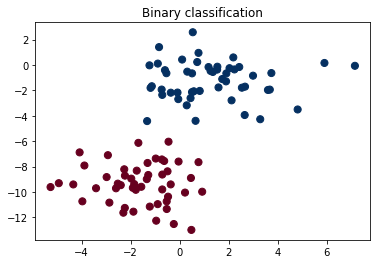

In [ ]:
# cloud of points
X_train_plot = X_train.copy()
y_train_plot = y_train.copy()
X_train_plot, y_train_plot = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X_train_plot[:, 0], X_train_plot[:, 1], c=y_train_plot, s=50, cmap='RdBu')
plt.title('Binary classification');

In [ ]:
# plot confusion matrix
def mat_plot(y_true, y_pred): 
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [ ]:
# plot receiver operating characteristic
def roc_plot(model, y, X, lable, title):
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=lable % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()    

In [ ]:
# sanity check 
def sanity_check (y_pred):    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.title('Full data')
    pd.value_counts(
        target, normalize=True).plot.bar(figsize=(9, 3), 
        color=['blue', 'darkorange']
    )
    plt.subplot(1, 2, 2)
    plt.title('Train data')
    pd.value_counts(
        y_pred, normalize=True).plot.bar(figsize=(9, 3), 
        color=['blue', 'darkorange']
    );

### Step 3. Application of classification algorithms for machine learning

### Logistic Regression

In [ ]:
# Logistic Regression
Image(url="https://miro.medium.com/max/391/1*25whI_Jt8LQIHhF6ds-j6Q.png")

In [ ]:
# Logistic Regression model
reg = LogisticRegression(
    penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
    class_weight=None, random_state=None, solver='newton-cg', max_iter=500, multi_class='auto', 
    verbose=0, warm_start=False, n_jobs=None, l1_ratio=None
)
reg.fit(X_train, y_train, sample_weight=None) # training
y_pred_reg = reg.predict(X_test) # predictions

In [ ]:
# scaler function
scaler_reg = StandardScaler().fit(X_train)
scaler_reg

StandardScaler()

In [ ]:
# mean values
scaler_reg.mean_

array([   63.07987552,    37.40041494, 17265.22905602])

In [ ]:
# scale values
scaler_reg.scale_

array([  33.69890245,   35.78993634, 7475.05844677])

In [ ]:
# transform X_train
X_scaled_reg = scaler_reg.transform(X_train)
X_scaled_reg

array([[-1.30805078, -0.7097083 , -1.73273148],
       [ 0.26470074,  1.41379366, -0.42321262],
       [-0.09139394, -0.57000423, -0.5011585 ],
       ...,
       [ 0.79884277,  0.32410186,  0.04965459],
       [-1.18935255, -1.04499808, -1.40231533],
       [-1.54544723, -0.3464777 , -0.56881148]])

In [ ]:
# find optimal hyperparameters for the model
def model_valid_LG():    
    # define dataset
    X_scaled_reg, y_train = make_blobs(
        n_samples=1000, centers=2, n_features=100, cluster_std=20
    )
    
    # define models and parameters
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    
    # define grid search
    grid = dict(solver=solvers, penalty=penalty, C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(
        estimator=model, param_grid=grid, n_jobs=-1,
        cv=cv, scoring='accuracy', error_score=0
    )
    grid_result = grid_search.fit(X_scaled_reg, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# optimal hyperparameters for the model
model_valid_LG()

Best: 0.975333 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.970000 (0.012910) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.968000 (0.012220) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.970667 (0.011235) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.970667 (0.012092) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.970667 (0.012365) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.970667 (0.011235) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.971333 (0.011470) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.971333 (0.011757) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.971000 (0.011060) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.972000 (0.011944) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.972000 (0.011944) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.972333 (0.010858) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.975333 (0.012311) wi

In [ ]:
# model accuracy (validation)
print('Accuracy of Logistic Regression classifier on validation set: {:.2f}'\
      .format(reg.score(X_val, y_val)))

Accuracy of Logistic Regression classifier on validation set: 0.75


In [ ]:
# model accuracy (test)
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'\
      .format(reg.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.76


"accuracy" is a ratio between number of true predictions and the total number of samples

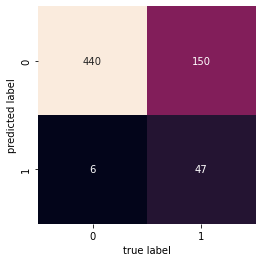

In [ ]:
# confusion matrix - Logistic Regression
mat_plot(y_test, y_pred_reg)

"confusion matrix" shows that there are 440+47 correct predictions and 150+6 incorrect ones

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85       446
           1       0.89      0.24      0.38       197

    accuracy                           0.76       643
   macro avg       0.82      0.61      0.61       643
weighted avg       0.79      0.76      0.70       643



"precision" is the ratio tp / (tp + fp), where tp is the number of true predictions and fp is the number of false predictions. "precision" characterizes the ability of the classifier not to label the sample as positive if it is negative.

"recall" is the ratio tp / (tp + fn), where tp is the number of true positives and fn is the number of false negatives. "recall" characterizes the ability of the classifier to find all positive samples.

"f1-score" is a weighted harmonic mean of "precision" and "recall", where "f1-score" reaches its best value at 1 and its worst value at 0.
"f1-score" characterizes the relationship between "precision" and "recall". If "f1-score" = 1, it means that "precision" and "recall" are equally important.

"support" is the number of occurrences of each class (tariffs) in y_test.

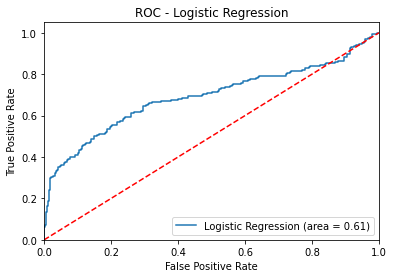

In [ ]:
# ROC Curve - Logistic Regression
roc_plot(reg, y_test, X_test, 'Logistic Regression (area = %0.2f)', 
        'ROC - Logistic Regression')

The dashed-dotted red line shows a purely random classifier. The blue curve characterizes the performance of the classifier for this algorithm. The more the curve deviates towards the upper left corner, the better the model performs.

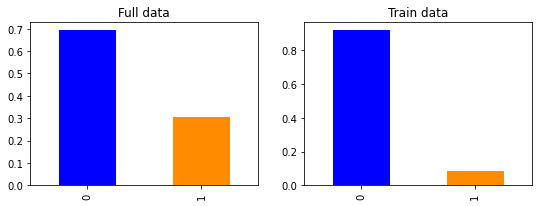

In [ ]:
# sanity check for Logistic Regression model
sanity_check (y_pred_reg)

### Decision Tree

In [ ]:
# Decision Tree
Image(url="https://miro.medium.com/max/379/1*fSlQBEta5GKjNgZGsVTVTA.png")

In [ ]:
# Decision Tree model
dtc = DecisionTreeClassifier(
	criterion='gini', splitter='best', max_depth=4, min_samples_split=2, 
	min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
	random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
	class_weight=None, ccp_alpha=0.0
	)
dtc.fit(X_train, y_train, sample_weight=None)
y_pred_dtc = dtc.predict(X_test)

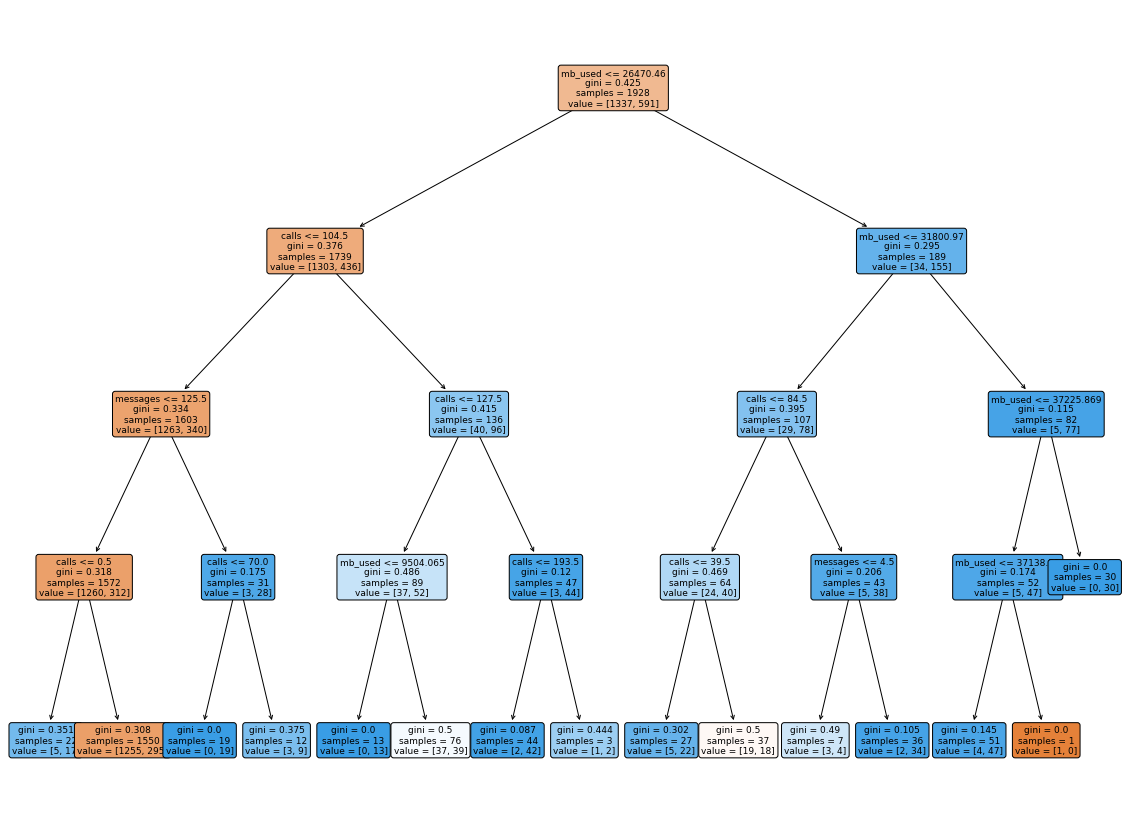

In [ ]:
# tree vizualization
plt.figure(figsize=(20,15))  
_ = tree.plot_tree(
    dtc, feature_names = X_train.columns, filled=True, fontsize=9, rounded=True
)
plt.show()

In [ ]:
# model accuracy (validation)
def model_valid_DT(max_value):
	best_depth = 0
	best_result = 0
	for depth in range(1, max_value):
		# training the model with depth of tree defined
		model = DecisionTreeClassifier(random_state=777, max_depth=depth) 
		model.fit(X_train, y_train) # training
		predictions = model.predict(X_val) # predictions
		result = accuracy_score(y_val, predictions) # calculate model accuracy
		if result > best_result:
			best_result = result
			best_depth = depth
			
	print('Accuracy of the best Decision Tree classifier on validation set: {:.2f}'\
		.format(best_result))
	print('Best depth of the Decision Tree classifier on validation set:', best_depth)

model_valid_DT(max_value=6)		  

Accuracy of the best Decision Tree classifier on validation set: 0.79
Best depth of the Decision Tree classifier on validation set: 4


In [ ]:
# model accuracy (test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'\
      .format(dtc.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.80


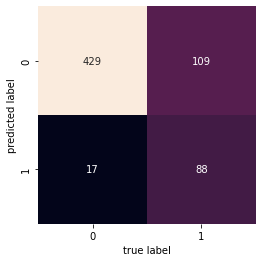

In [ ]:
# confusion matrix - Decision Tree
mat_plot(y_test, y_pred_dtc)

"confusion matrix" shows that there are 429+88 correct predictions and 109+17 incorrect ones

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       446
           1       0.84      0.45      0.58       197

    accuracy                           0.80       643
   macro avg       0.82      0.70      0.73       643
weighted avg       0.81      0.80      0.78       643



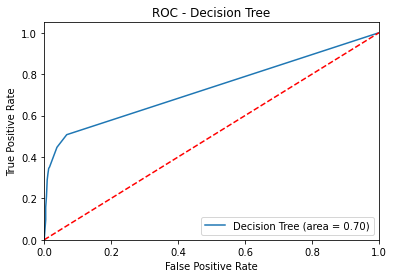

In [ ]:
# ROC Curve - Decision Tree
roc_plot(dtc, y_test, X_test, 'Decision Tree (area = %0.2f)', 
        'ROC - Decision Tree')

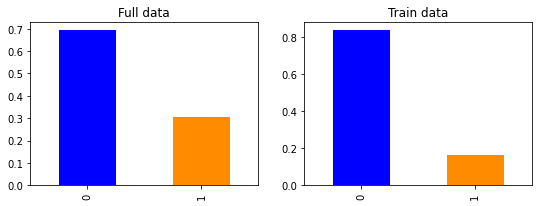

In [ ]:
# sanity check for Decision Tree model
sanity_check (y_pred_dtc)

### Random Forest

In [ ]:
# Random Forest
Image(url="https://miro.medium.com/max/443/1*fsy57DtqUR_UDOTQKtghkw.png")

In [ ]:
# Random Forest model
rfc = RandomForestClassifier(
    n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
    max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
    n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, 
    ccp_alpha=0.0, max_samples=None
)
rfc.fit(X_train, y_train, sample_weight=None)
y_pred_rfc = rfc.predict(X_test)

In [ ]:
# model accuracy (validation)
def model_valid_RF(max_value):
    best_result = 0
    best_number = 0    
    for est in range(1, max_value):
        # training the model with number of trees defined
        model = RandomForestClassifier(random_state=777, n_estimators=est) 
        model.fit(X_train, y_train) # training
        result = model.score(X_val, y_val) # calculate model accuracy
        if result > best_result:
            best_result = result
            best_number = est

    print('Accuracy of the best Random Forest classifier on validation set: {:.2f}'\
		.format(best_result))
    print('Best number of trees of the Random Forest classifier on validation set:',\
        best_number)

model_valid_RF(max_value=11)

Accuracy of the best Random Forest classifier on validation set: 0.80
Best number of trees of the Random Forest classifier on validation set: 10


In [ ]:
# model accuracy (test)
print('Accuracy of Random Forest classifier on test set: {:.2f}'\
      .format(rfc.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.80


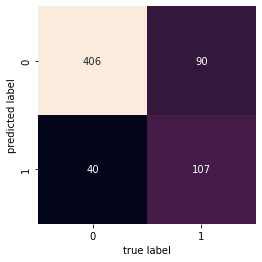

In [ ]:
# confusion matrix - Random Forest
mat_plot(y_test, y_pred_rfc)

"confusion matrix" shows that there are 410+103 correct predictions and 94+36 incorrect ones

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       446
           1       0.73      0.54      0.62       197

    accuracy                           0.80       643
   macro avg       0.77      0.73      0.74       643
weighted avg       0.79      0.80      0.79       643



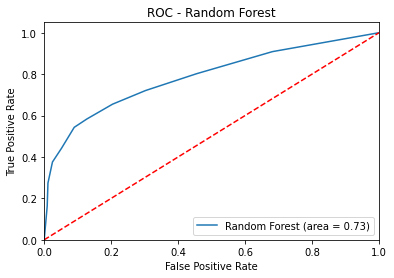

In [ ]:
# ROC Curve - Random Forest
roc_plot(rfc, y_test, X_test, 'Random Forest (area = %0.2f)', 
        'ROC - Random Forest')

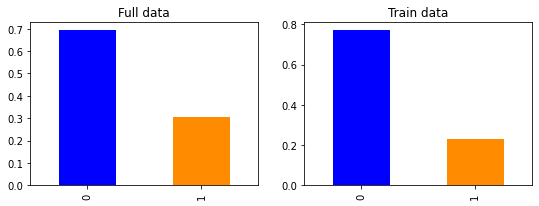

In [ ]:
# sanity check for Random Forest model
sanity_check (y_pred_rfc)

### Support Vector Machine (SVM)

In [ ]:
# Support Vector Machine (SVM)
Image(url="https://miro.medium.com/max/376/1*WMbKMcC-gfXe4JgzcSxN2Q.png")

In [ ]:
# SVM model
svc = SVC(
    C=10, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
    probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
    max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None
)
svc.fit(X_train, y_train, sample_weight=None)
y_pred_svc = svc.predict(X_test)

In order to find the optimal parameters, various combinations have to be worked out and seen what has the best performance. To do this, a "grid" of parameters is created. This method is built into GridSearchCV.

GridSearchCV uses a dictionary describing the parameters and model for training. The settings grid is defined as a dictionary where the keys are the settings and the values ​​are the parameters tested.

GridSearchCV is a meta-estimator. It takes an estimator like SVC and creates a new estimator that behaves exactly like a classifier.

During training, a cross-validation loop is run to find the best combination of parameters. Once it has the best combination, it re-fits all the data passed in for fitting (without cross-validation) to build a single new model using the best combination of parameters.

In [ ]:
# grid of parameters
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']
} 

In [ ]:
# create a new estimator
# 'verbose' - text output describing the process
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

In [ ]:
# training
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.692 total time=   0.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.692 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.694 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# best parameters
grid.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

In [ ]:
# best estimator
grid.best_estimator_

SVC(C=10, gamma=0.0001)

In [ ]:
# model accuracy (validation)
print('Accuracy of SVM classifier on validation set: {:.2f}'\
      .format(svc.score(X_val, y_val)))

Accuracy of SVM classifier on validation set: 0.73


In [ ]:
# model accuracy (test)
print('Accuracy of SVM classifier on test set: {:.2f}'\
      .format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.75


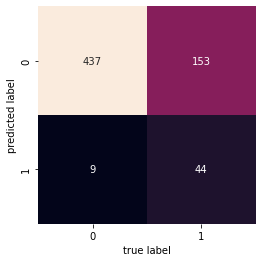

In [ ]:
# confusion matrix - SVM
mat_plot(y_test, y_pred_svc)

"confusion matrix" shows that thre are 437+44 correct predictions and 153+9 incorrect ones

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84       446
           1       0.83      0.22      0.35       197

    accuracy                           0.75       643
   macro avg       0.79      0.60      0.60       643
weighted avg       0.77      0.75      0.69       643



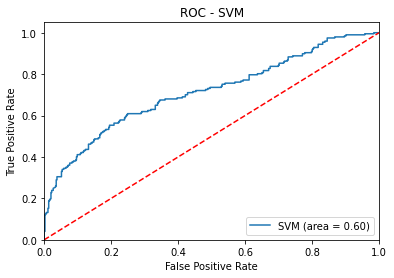

In [ ]:
# ROC Curve - SVM
roc_plot(svc, y_test, X_test, 'SVM (area = %0.2f)', 
        'ROC - SVM')

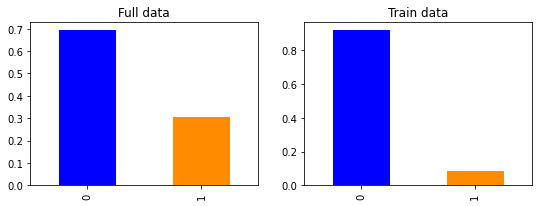

In [ ]:
# sanity check for SVM model
sanity_check (y_pred_svc)

### K-Nearest Neighbour (KNN)

In [ ]:
# K-Nearest Neighbour (KNN)
Image(url="https://miro.medium.com/max/390/1*-IOhINAS4oEFJnutXGHJDA.png")

In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
    metric='minkowski', metric_params=None, n_jobs=None
)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [ ]:
# model accuracy (validation)
print('Accuracy of KNN classifier on validation set: {:.2f}'\
      .format(knn.score(X_val, y_val)))

Accuracy of KNN classifier on validation set: 0.68


In [ ]:
# model accuracy (test)
print('Accuracy of KNN classifier on test set: {:.2f}'\
      .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.69


In [ ]:
# confusion_matrix
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(confusion_matrix_knn)

[[358  88]
 [112  85]]


In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       446
           1       0.49      0.43      0.46       197

    accuracy                           0.69       643
   macro avg       0.63      0.62      0.62       643
weighted avg       0.68      0.69      0.68       643



Since the KNN classifier predicts the class of a given test observation, when determining the closest observation to it, the scale of the variables matters. Any large scale variables will have a more significant impact on the distance between observations and hence on the KNN classifier than small scale variables.

In [ ]:
# assign StandardScaler function to the variable
scaler_knn = StandardScaler()

In [ ]:
# remove the mean and scale each feature to unit variance
scaler_knn.fit(df1.drop('is_ultra', axis=1))

StandardScaler()

In [ ]:
# transform the features
scaled_features = scaler_knn.transform(df1.drop('is_ultra', axis=1))
print(scaled_features)

[[-0.69329109  1.23728246  0.35770425]
 [ 0.66085817  0.49024367  0.72515696]
 [ 0.42012052  1.32028677  0.50896735]
 ...
 [ 1.02196463  0.87759711 -0.4271735 ]
 [ 0.02892185  1.43095918  1.85369812]
 [ 0.51039714 -0.8931615   1.62129274]]


In [ ]:
# set aside 40% of train and validation data
X_train_sc, X_val_sc, y_train_sc, y_val_sc = train_test_split(scaled_features, target, 
    test_size=0.4, random_state=777, stratify=target)

# use the same function above for the test set
X_val_sc, X_test_sc, y_val_sc, y_test_sc = train_test_split(X_val_sc, y_val_sc, 
    test_size=0.5, random_state=777, stratify=y_val_sc)  

To optimize the model, the best K-value has to be chosen

In [ ]:
# pick up the best k-value
error_rate = []
for i in range(1, 40):
    knn_opt = KNeighborsClassifier(n_neighbors=i)
    knn_opt.fit(X_train_sc, y_train_sc)
    pred_i = knn_opt.predict(X_test_sc)
    error_rate.append(np.mean(pred_i != y_test_sc))

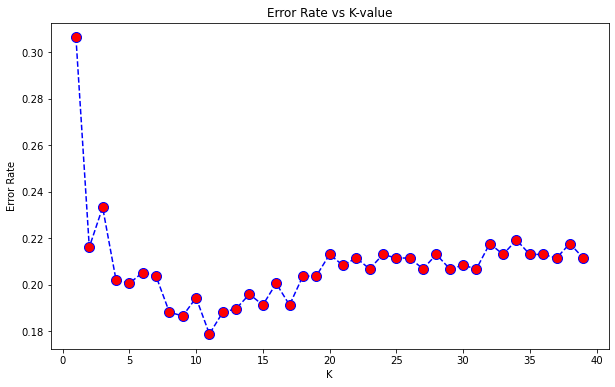

In [ ]:
# print out graph Error Rate vs K-value
plt.figure(figsize=(10,6))
plt.plot(
    range(1,40), error_rate, color='blue', linestyle='dashed', marker='o',
    markerfacecolor='red', markersize=10
)
plt.title('Error Rate vs K-value')
plt.xlabel('K')
plt.ylabel('Error Rate');

As seen from the graph, the optimal K-value = 11

In [ ]:
# K-value = 1
knn_K1 = KNeighborsClassifier(n_neighbors=1)

knn_K1.fit(X_train_sc, y_train_sc)
y_pred_knn_K1 = knn_K1.predict(X_test_sc)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test, y_pred_knn_K1))
print('\n')
print(classification_report(y_test, y_pred_knn_K1))

WITH K=1


[[349  97]
 [100  97]]


              precision    recall  f1-score   support

           0       0.78      0.78      0.78       446
           1       0.50      0.49      0.50       197

    accuracy                           0.69       643
   macro avg       0.64      0.64      0.64       643
weighted avg       0.69      0.69      0.69       643



In [ ]:
# K-value = 11
knn_K11 = KNeighborsClassifier(n_neighbors=11)

knn_K11.fit(X_train_sc, y_train_sc)
y_pred_knn_K11 = knn_K11.predict(X_test_sc)

print('WITH K=11')
print('\n')
print(confusion_matrix(y_test, y_pred_knn_K11))
print('\n')
print(classification_report(y_test, y_pred_knn_K11))

WITH K=11


[[427  19]
 [ 96 101]]


              precision    recall  f1-score   support

           0       0.82      0.96      0.88       446
           1       0.84      0.51      0.64       197

    accuracy                           0.82       643
   macro avg       0.83      0.74      0.76       643
weighted avg       0.82      0.82      0.81       643



In [ ]:
# model accuracy (test) for K-value = 12
print('Accuracy of Decision Tree classifier (optimized) on test set: {:.2f}'\
      .format(knn_K11.score(X_test_sc, y_test_sc)))

Accuracy of Decision Tree classifier (optimized) on test set: 0.82


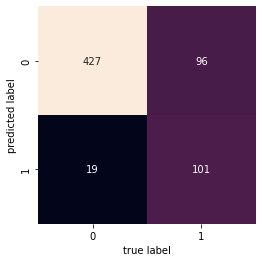

In [ ]:
# confusion matrix - KNN
mat_plot(y_test, y_pred_knn_K11)

"confusion matrix" shows that 427+101 correct predictions and 96+19 incorrect ones

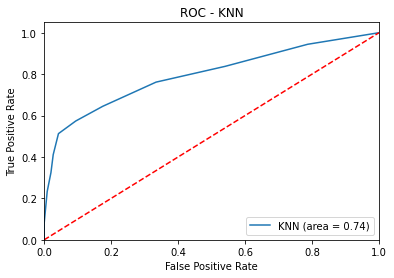

In [ ]:
# ROC Curve - KNN
roc_plot(knn_K11, y_test_sc, X_test_sc, 'KNN (area = %0.2f)', 
        'ROC - KNN')

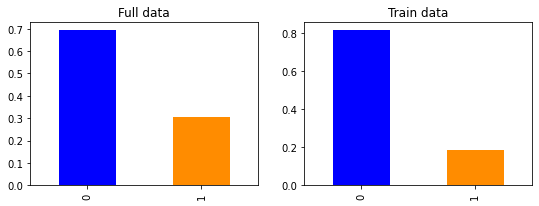

In [ ]:
# sanity check for KNN model
sanity_check (y_pred_knn_K11)

### Naive Bayes

In [ ]:
# Naive Bayes
Image(url="https://miro.medium.com/max/396/1*tYTrLRcVBBEsCqSUxFDHHA.png")

In [ ]:
# normalization of features
features_norm = (features - np.min(features)) / (np.max(features) - np.min(features))
display(features_norm.head())

,calls,messages,mb_used
0,0.16,3.71e-01,0.40
1,0.35,2.50e-01,0.46
2,0.32,3.84e-01,0.42
3,0.43,3.62e-01,0.17
4,0.27,4.46e-03,0.29


In [ ]:
# set aside 40% of train and validation data
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(features_norm, target, 
    test_size=0.4, random_state=777, stratify=target)

# use the same function above for the test set
X_val_n, X_test_n, y_val_n, y_test_n = train_test_split(X_val_n, y_val_n, 
    test_size=0.5, random_state=777, stratify=y_val_n)  

#### Gaussian Naive Bayes

In [ ]:
# Gaussian Naive Bayes model
gnb = GaussianNB(priors=None, var_smoothing=1e-09)
gnb.fit(X_train_n, y_train_n)
y_pred_gnb = gnb.predict(X_test_n)

In [ ]:
# model accuracy (validation)
print('Accuracy of Gaussian Naive Bayes classifier on validation set: {:.2f}'\
      .format(gnb.score(X_val_n, y_val_n)))

Accuracy of Gaussian Naive Bayes classifier on validation set: 0.78


In [ ]:
# model accuracy (test)
print('Accuracy of Gaussian Naive Bayes classifier on test set: {:.2f}'\
      .format(gnb.score(X_test_n, y_test_n)))

Accuracy of Gaussian Naive Bayes classifier on test set: 0.77


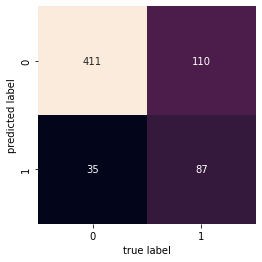

In [ ]:
# confusion matrix - Gaussian Naive Bayes
mat_plot(y_test_n, y_pred_gnb)

"confusion matrix" shows that 411+87 correct predictions and 110+35 incorrect ones

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_test_n, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       446
           1       0.71      0.44      0.55       197

    accuracy                           0.77       643
   macro avg       0.75      0.68      0.70       643
weighted avg       0.77      0.77      0.76       643



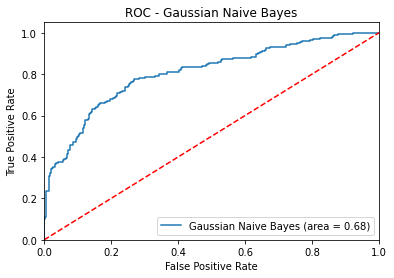

In [ ]:
# ROC Curve - Gaussian Naive Bayes
roc_plot(gnb, y_test_n, X_test_n, 'Gaussian Naive Bayes (area = %0.2f)', 
        'ROC - Gaussian Naive Bayes')

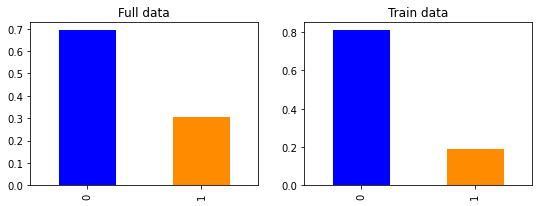

In [ ]:
# sanity check for Gaussian Naive Bayes model
sanity_check (y_pred_gnb)

#### Bernoulli Naive Bayes

In [ ]:
# Bernoulli Naive Bayes model
bnb = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
bnb.fit(X_train_n, y_train_n)
y_pred_bnb = bnb.predict(X_test_n)

In [ ]:
# model accuracy (validation)
print('Accuracy of Bernoulli Naive Bayes classifier on validation set: {:.2f}'\
      .format(bnb.score(X_val_n, y_val_n)))

Accuracy of Bernoulli Naive Bayes classifier on validation set: 0.70


In [ ]:
# model accuracy (test)
print('Accuracy of Bernoulli Naive Bayes classifier on test set: {:.2f}'\
      .format(bnb.score(X_test_n, y_test_n)))

Accuracy of Bernoulli Naive Bayes classifier on test set: 0.71


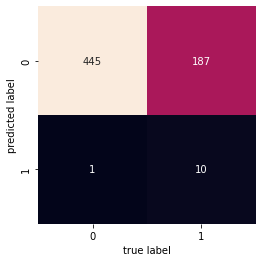

In [ ]:
# confusion matrix - Bernoulli Naive Bayes
mat_plot(y_test_n, y_pred_bnb)

"confusion matrix" shows that 445+10 correct predictions and 187+1 incorrect ones

In [ ]:
# compute precision, recall, F-measure and support
print(classification_report(y_test_n, y_pred_bnb))

              precision    recall  f1-score   support

           0       0.70      1.00      0.83       446
           1       0.91      0.05      0.10       197

    accuracy                           0.71       643
   macro avg       0.81      0.52      0.46       643
weighted avg       0.77      0.71      0.60       643



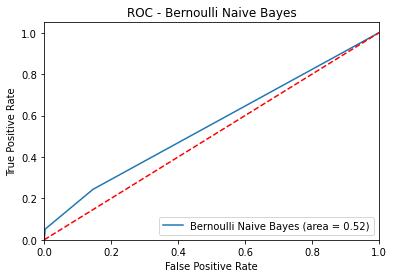

In [ ]:
# ROC Curve - Bernoulli Naive Bayes
roc_plot(bnb, y_test_n, X_test_n, 'Bernoulli Naive Bayes (area = %0.2f)', 
        'ROC - Bernoulli Naive Bayes')

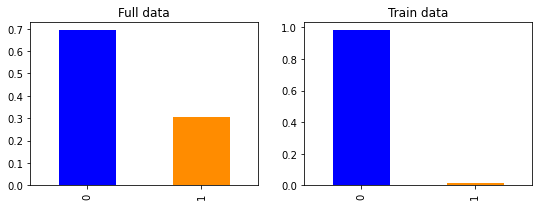

In [ ]:
# sanity check for Bernoulli Naive Bayes model
sanity_check (y_pred_bnb)

### Step 4. Comparison of models

In [ ]:
# accuracy of ML models
reg_p = round(reg.score(X_test, y_test), 2)
dtc_p = round(dtc.score(X_test, y_test), 2)
rfc_p = round(rfc.score(X_test, y_test), 2)
svc_p = round(svc.score(X_test, y_test), 2)
knn_p = round(knn_K11.score(X_test_sc, y_test_sc), 2)
gnb_p = round(gnb.score(X_test_n, y_test_n), 2)
bnb_p = round(bnb.score(X_test_n, y_test_n), 2)

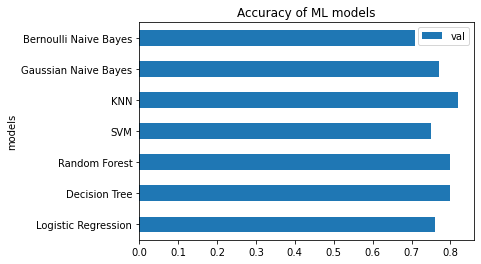

In [ ]:
# dataframe for analysis
perform = pd.DataFrame(
    {'models': ['Logistic Regression', 
                'Decision Tree', 
                'Random Forest', 
                'SVM', 
                'KNN', 
                'Gaussian Naive Bayes', 
                'Bernoulli Naive Bayes'], 
     'val': [reg_p, dtc_p, rfc_p, svc_p, knn_p, gnb_p, bnb_p]}
)
ax = perform.plot.barh(x='models', y='val', title='Accuracy of ML models')

In [ ]:
# accuracy of top ML models
display(perform.sort_values(by=['val'], ascending=False, ignore_index=True))

,models,val
0,KNN,0.82
1,Decision Tree,0.80
2,Random Forest,0.80
3,Gaussian Naive Bayes,0.77
4,Logistic Regression,0.76
5,SVM,0.75
6,Bernoulli Naive Bayes,0.71


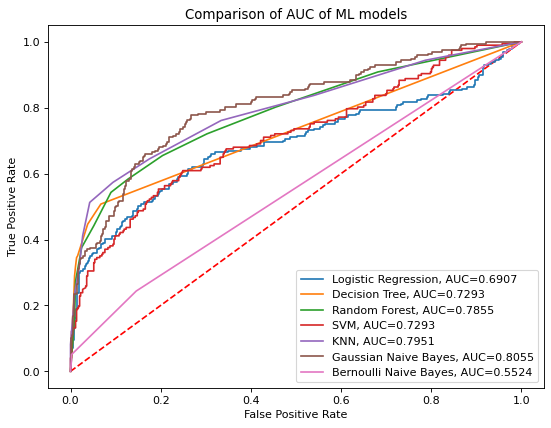

In [ ]:
# set up plotting area
plt.figure(0, figsize=(8, 6), dpi=80).clf()
plt.plot([0, 1], [0, 1],'r--')
plt.title('Comparison of AUC of ML models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Logistic Regression
y_pred_reg_plot = reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_reg_plot)
auc = round(metrics.roc_auc_score(y_test, y_pred_reg_plot), 4)
plt.plot(fpr, tpr, label="Logistic Regression, AUC="+str(auc))

# Decision Tree
y_pred_dtc_plot = dtc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_dtc_plot)
auc = round(metrics.roc_auc_score(y_test, y_pred_dtc_plot), 4)
plt.plot(fpr, tpr, label="Decision Tree, AUC="+str(auc))

# Random Forest
y_pred_rfc_plot = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_rfc_plot)
auc = round(metrics.roc_auc_score(y_test, y_pred_rfc_plot), 4)
plt.plot(fpr, tpr, label="Random Forest, AUC="+str(auc))

# SVM
y_pred_svc_plot = svc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_svc_plot)
auc = round(metrics.roc_auc_score(y_test, y_pred_dtc_plot), 4)
plt.plot(fpr, tpr, label="SVM, AUC="+str(auc))

# KNN
y_pred_knn_plot = knn_K11.predict_proba(X_test_sc)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_sc, y_pred_knn_plot)
auc = round(metrics.roc_auc_score(y_test_sc, y_pred_knn_plot), 4)
plt.plot(fpr, tpr, label="KNN, AUC="+str(auc))

# Gaussian Naive Bayes
y_pred_gnb_plot = gnb.predict_proba(X_test_n)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_n, y_pred_gnb_plot)
auc = round(metrics.roc_auc_score(y_test_n, y_pred_gnb_plot), 4)
plt.plot(fpr, tpr, label="Gaussian Naive Bayes, AUC="+str(auc))

# Bernoulli Naive Bayes
y_pred_bnb_plot = bnb.predict_proba(X_test_n)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_n, y_pred_bnb_plot)
auc = round(metrics.roc_auc_score(y_test_n, y_pred_bnb_plot), 4)
plt.plot(fpr, tpr, label="Bernoulli Naive Bayes, AUC="+str(auc))

# add legend
plt.legend();

### Conclusions

The results of the research show that KNN has the best accuracy (0.82), as well as Decision Tree and Random Forest with a score of 0.80.

AUC partly confirms the trend, with Gaussian Naive Bayes leading at 0.8055 and KNN at 0.7951.

The Confusion matrix for KNN shows the proportion of correct/incorrect values ​​as 528/115, which is the best result. It is followed by Decision Tree (517/126).

Additionally, the F-score for KNN is calculated based on the values ​​of precision and recall, which is 0.81. The ideal value should tend to 1. This is because the model is balanced, so that precision and recall are equally important for machine learning.

Besides, the high performance of KNN is provided due to data scaling and the use of an optimization algorithm to find the best K-value, at which the minimum Error Rate is achieved.